In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import pickle
import random
import collections
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

True

In [15]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY")
)

ModuleNotFoundError: No module named 'openai'

# Look at data files

## Risk Factors 

In [2]:
!ls ../data/raw

id_arabic_location_name.pkl  news-articles-eng.csv
id_english_location_name.pkl risk-factors-categories.xlsx
news-articles-ara.csv        risk-factors.xlsx


In [6]:
df_risk_factors = pd.read_excel("../data/raw/risk-factors.xlsx")

In [8]:
print(df_risk_factors.shape)
df_risk_factors.head()

(167, 2)


,risk_factor_english,risk_factor_arabic
0,massive starvation,NaN
1,rinderpest,NaN
2,scanty rainfall,NaN
3,dysfunction,NaN
4,rise,NaN


In [21]:
df_risk_factors_categories = pd.read_excel("../data/raw/risk-factors-categories.xlsx")
df_risk_factors_categories.head(2)

,risk_factor,cluster
0,land seizures,land-related issues
1,slashed export,economic issues


In [24]:
pd.unique(df_risk_factors_categories['cluster'])

array(['land-related issues', 'economic issues', 'food crisis',
       'weather shocks', 'agricultural production issues',
       'humanitarian aid', 'political instability', 'pests and diseases',
       'other', 'conflicts and violence', 'forced displacement',
       'environmental issues'], dtype=object)

In [25]:
df_risk_factors_categories['risk_factor'].value_counts()

risk_factor
land seizures     1
slashed export    1
price rise        1
mass hunger       1
cyclone           1
                 ..
convoys           1
carbon            1
mayhem            1
dehydrated        1
mismanagement     1
Name: count, Length: 167, dtype: int64

## News Articles

In [12]:
df_news_en = pd.read_csv("../data/raw/news-articles-eng.csv")

In [27]:
print(df_news_en.shape)
df_news_en.head(2)

(86660, 20)


,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,source,authors,image,eventUri,sentiment,wgt,relevance,userHasPermissions
0,8216521939,eng,False,2024-07-09,08:15:07,2024-07-09T08:15:07Z,2024-07-09T08:14:39Z,news,0.631373,https://english.enabbaladi.net/archives/2024/0...,Israeli escalation on southern Lebanon : Al-As...,Hussam al-Mahmoud | Yamen Moghrabi | Hassan Ib...,"{'uri': 'english.enabbaladi.net', 'dataType': ...","[{'uri': 'enab10_ula@english.enabbaladi.net', ...",https://cdn.enabbaladi.net/english/wp-content/...,eng-9713305,-0.505882,503,503,NaN
1,8235923227,eng,False,2024-07-21,08:16:52,2024-07-21T08:16:52Z,2024-07-21T08:16:12Z,news,0.000000,https://www.jewishpress.com/indepth/analysis/j...,"Israel Should NOT be Stuck with a ""Fair Fight""...",t's an excellent axiom to never put your citiz...,"{'uri': 'jewishpress.com', 'dataType': 'news',...","[{'uri': 'j_e_dyer@jewishpress.com', 'name': '...",https://www.jewishpress.com/wp-content/uploads...,NaN,0.003922,477,477,NaN


In [15]:
df_news_ar = pd.read_csv("../data/raw/news-articles-ara.csv")

In [28]:
print(df_news_ar.shape)
df_news_ar.head(2)

(85511, 19)


,uri,lang,isDuplicate,date,time,dateTime,dateTimePub,dataType,sim,url,title,body,source,authors,image,eventUri,sentiment,wgt,relevance
0,8221345226,ara,False,2024-07-12,00:55:33,2024-07-12T00:55:33Z,2024-07-12T00:55:00Z,news,0.615686,https://www.almanar.com.lb/12211949,الصحافة اليوم: 12-7-2024,‫‫ محمد الهندي: من يرى فيديوهات المقاومين يجب ...,"{'uri': 'almanar.com.lb', 'dataType': 'news', ...",[],https://www.almanar.com.lb/framework/includes/...,ara-1673095,NaN,533,533
1,8202585568,ara,False,2024-06-30,10:00:50,2024-06-30T10:00:50Z,2024-06-30T10:00:18Z,news,0.000000,https://www.enabbaladi.net/706124/انفجار-جنوبي...,انفجار جنوبي لبنان.. الأسد حاضر دون أدوات,حسام المحمود | يامن المغربي | حسن إبراهيم\n\nأ...,"{'uri': 'enabbaladi.net', 'dataType': 'news', ...",[],https://cdn.enabbaladi.net/arabic/wp-content/u...,NaN,NaN,516,516


In [ ]:
assert df_news_en['lang'].unique()[0] == 'eng'
assert df_news_ar['lang'].unique()[0] == 'ara'
# Check all languages are as expected

In [ ]:
for en,ar in zip(df_news_en.columns, df_news_ar.columns):
    print(en, ar)
# En and Ar news have mostly same schema (en has permissions column not in ar)
# Useful columns likely to be: dateTimePub, body
# Not clear where relevance and other columns come from

uri uri
lang lang
isDuplicate isDuplicate
date date
time time
dateTime dateTime
dateTimePub dateTimePub
dataType dataType
sim sim
url url
title title
body body
source source
authors authors
image image
eventUri eventUri
sentiment sentiment
wgt wgt
relevance relevance


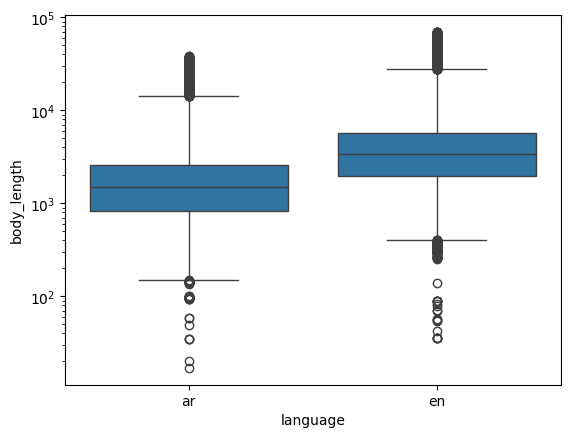

In [ ]:
df_box = pd.DataFrame({
    'body_length': pd.concat([
        df_news_ar['body'].str.len().rename('ar'),
        df_news_en['body'].str.len().rename('en')
    ]),
    'language': ['ar'] * len(df_news_ar) + ['en'] * len(df_news_en)
})

_ = sns.boxplot(x='language', y='body_length', data=df_box, log_scale=True)

# Articles are of comparable length, Arabic slightly longer


In [76]:
df_news_en['dateTime'] = pd.to_datetime(df_news_en['dateTime'])
df_news_ar['dateTime'] = pd.to_datetime(df_news_ar['dateTime'])
# Convert to datetime

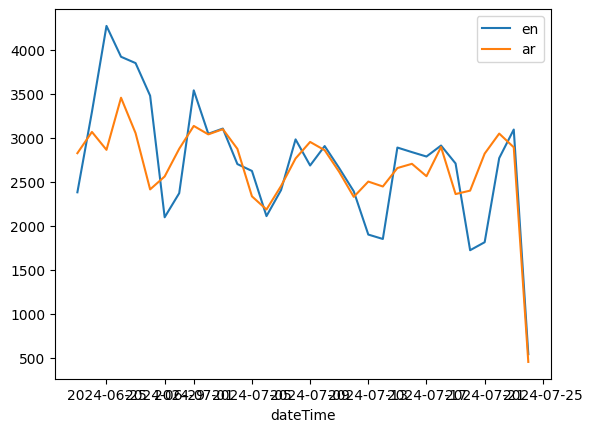

In [ ]:
ax = df_news_en.groupby(df_news_en['dateTime'].dt.date).size().plot()
ax = df_news_ar.groupby(df_news_ar['dateTime'].dt.date).size().plot(ax=ax)
ax.legend(['en', 'ar'])

# Daily volumes are comparable with weekly dynamics

## Location files

In [4]:
with open("../data/raw/id_english_location_name.pkl", "rb") as f:
    locations_dict_en = pickle.load(f)

In [5]:
list(locations_dict_en.items())[:10]  # Show first 5 items

[('iq', ['iraq']),
 ('jo', ['jordan']),
 ('lb', ['lebanon']),
 ('ps',
  ['occupied palestinian territory',
   'palestine',
   'palestinian authority',
   'palestinian territories']),
 ('sy', ['syria', 'syrian arab republic']),
 ('iq_an', ['anbar']),
 ('iq_ar', ['arbil', 'erbil']),
 ('iq_bb', ['babil', 'babylon']),
 ('iq_bg', ['baghdad']),
 ('iq_ba', ['basra', 'basrah'])]

In [6]:
random.sample(list(locations_dict_en.items()), 10)  # Show 10 random items

[('iq_00_11', ['saidsadiq']),
 ('lb_na_3', ['marjaayoun', 'marjeyoun']),
 ('iq_ma_2', ['maimouna']),
 ('iq_sd_7', ['samarra']),
 ('iq_da', ['dahuk', 'duhok']),
 ('sy_hm', ['hama']),
 ('iq_bg_6', ["mada'in"]),
 ('lb_jl', ['mount lebanon']),
 ('iq_sl_1', ['chamchamal']),
 ('iq_mu', ['muthanna'])]

In [7]:
with open("../data/raw/id_arabic_location_name.pkl", "rb") as f:
    locations_dict_ar = pickle.load(f)

In [8]:
list(locations_dict_ar.items())[:10]  # Show first 5 items

[('iq', array(['العراق'], dtype=object)),
 ('jo', array(['الأردن'], dtype=object)),
 ('lb', array(['لبنان'], dtype=object)),
 ('ps',
  array(['السلطة الوطنية الفلسطينية', 'الضفة الغربية وقطاع غزة',
         'دولة فلسطين', 'فلسطين'], dtype=object)),
 ('sy', array(['سوريا'], dtype=object)),
 ('iq_an', array(['الأنبار', 'الانبار'], dtype=object)),
 ('iq_ar', array(['أربيل', 'اربيل'], dtype=object)),
 ('iq_bb', array(['بابل'], dtype=object)),
 ('iq_bg', array(['بغداد'], dtype=object)),
 ('iq_ba', array(['البصرة'], dtype=object))]

In [9]:
random.sample(list(locations_dict_ar.items()), 10)  # Show 10 random items

[('lb_na_3', array(['مرجعيون'], dtype=object)),
 ('iq_ni_1', array(['عقرة'], dtype=object)),
 ('sy_rd_2', array(['النبك'], dtype=object)),
 ('iq_ar_3', array(['كويسنجق'], dtype=object)),
 ('jo_aj_1', array(['قصبة عجلون'], dtype=object)),
 ('iq_bg', array(['بغداد'], dtype=object)),
 ('iq_dq', array(['ذي قار'], dtype=object)),
 ('jo_am_5', array(['ماركا'], dtype=object)),
 ('lb_nl', array(['الشمال'], dtype=object)),
 ('jo_am_6', array(['ناعور'], dtype=object))]

Provinces : admin-1 and Districts : admin-2.   
English and Arabic seem to have same schema.  
To extract locations from news articles will need to reverse mapping of this dictionary i.e. many-to-one : ``<non unique name> : <location_id>``

In [10]:
locations_dict_en_reversed = collections.defaultdict(list)

for k,v in locations_dict_en.items():
    for vv in v:
        locations_dict_en_reversed[vv].append(k)
        
locations_dict_ar_reversed = collections.defaultdict(list)

for k,v in locations_dict_ar.items():
    for vv in v:
        locations_dict_ar_reversed[vv].append(k)

In [11]:
for k,v in random.sample(list(locations_dict_en_reversed.items()), 5):
    print(k,v)
print()
for k,v in random.sample(list(locations_dict_ar_reversed.items()), 5):
    print(k,v)

jenin ['ps_wb_5']
rutba ['iq_an_2']
zakho ['iq_da_4']
mount lebanon ['lb_jl']
hai ['iq_wa_2']

الميادين ['sy_dy_3']
مادبا ['jo_md', 'jo_md_1']
طرابلس ['lb_nl_5']
مركز إدلب ['sy_id_5']
البعاج ['iq_ni_2']


In [12]:
print(collections.Counter(map(len, locations_dict_en_reversed.values())))

print(collections.Counter(map(len, locations_dict_ar_reversed.values())))
# Minority of location names map to multiple location IDs

Counter({1: 511, 2: 48})
Counter({1: 319, 2: 39, 3: 1})


In [15]:
list(locations_dict_ar.keys())[0:10]

['iq', 'jo', 'lb', 'ps', 'sy', 'iq_an', 'iq_ar', 'iq_bb', 'iq_bg', 'iq_ba']

In [ ]:
print(collections.Counter(map(lambda x:x[0:2], locations_dict_en.keys())))
print(collections.Counter(map(lambda x:x[0:2], locations_dict_ar.keys())))
# Same countries feature

Counter({'iq': 145, 'sy': 81, 'jo': 76, 'lb': 36, 'ps': 19})
Counter({'iq': 145, 'sy': 81, 'jo': 76, 'lb': 36, 'ps': 19})


In [ ]:
with open("../data/processed/ar_locations_reversed.pkl", "wb") as f:
    pickle.dump(locations_dict_ar_reversed, f)

with open("../data/processed/en_locations_reversed.pkl", "wb") as f:
    pickle.dump(locations_dict_en_reversed, f)
    
# Save to disk